In [1]:
import openai
from openai import AzureOpenAI
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, RocCurveDisplay
import time 

# Initialize Azure OpenAI Client

In [ ]:
client = AzureOpenAI(
    api_key="<API_KEY>",
    azure_endpoint="<ENDPOINT>",
    api_version="2024-10-01-preview",
    #azure_deployment="gpt-4o-mini"
)

# Create Chat Completion Prompt Response Function

In [3]:
def get_gpt_response(prompt: str, model: str = "gpt-4o-mini", temperature: float = 0.7, max_tokens: int = 250) -> str:
    try: 
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            temperature=temperature,
            max_tokens=max_tokens
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f'Error: {e}')
        return None

# In-Context Learning for Stroke Prediction
To take advantage of the In-Context Learning of GPT, we need to structures our prompts in order to guide our model into providing the desired output. 

In [5]:
prompt1 = 'Priotize the following factors in order of importance for a stroke prediction algorithm: gender, age, hypertension, heart disease, ever married, work type, residence type, average glucose level, bmi, and smoking status.'
response1 = get_gpt_response(prompt1, model="gpt-4o-mini", temperature=0.7, max_tokens=500)
print(response1)

When prioritizing factors for a stroke prediction algorithm, it's important to consider the established risk factors associated with stroke. Based on existing medical research and the relative risk each factor presents, here is a suggested order of importance:

1. **Hypertension** - One of the most significant risk factors for stroke.
2. **Age** - Stroke risk increases with age.
3. **Heart Disease** - A major risk factor that significantly increases the likelihood of stroke.
4. **Smoking Status** - Smoking is a well-known risk factor for many cardiovascular conditions, including stroke.
5. **Average Glucose Level** - High glucose levels can indicate diabetes, which is a risk factor for stroke.
6. **BMI** - Obesity (high BMI) is associated with various health issues, including increased stroke risk.
7. **Gender** - While both genders can have strokes, certain studies indicate that men may have a higher risk at younger ages, while women may catch up or surpass that risk at older ages.
8.

# Continue the conversation
Let'take the first set of prompts/reponses and lead our model to predicting if a patient has history of stroke. 

In [6]:
def continue_gpt_response(prompt1: str, response1: str, prompt2: str, model: str = "gpt-4o-mini", temperature: float = 0.7, max_tokens: int = 250) -> str:
    try: 
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt1},
                {"role": "system", "content": response1},
                {"role": "user", "content": prompt2}
            ],
            temperature=temperature,
            max_tokens=max_tokens
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f'Error: {e}')
        return None

In [14]:
prompt2 = 'Using the factors above and weighted by their importance, predict using if the following patient has a history of stroke.The patient gender is Male . The patient age group is senior . The patient has hypertension: True . The patient has heart disease: True . The patient is married: Yes . The patient work type is Private . The patient residence type is Rural . The patient glucose level group is normal . The patient BMI group is overweight . The patient smoking status is never smoked. Please predict with a single word response of True or False.'

response2 = continue_gpt_response(prompt1, response1, prompt2, model="gpt-4o-mini", temperature=0.7, max_tokens=250)
print(response2)

True


# Stroke Prediction Dataset
The first step of our Stroke GPT model is to collect the relevant data for our problem domain. 

In [8]:
stroke = 'healthcare-dataset-stroke-data.csv'
df = pd.read_csv(stroke)
df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Preprocessing/Feature Engineering
To prepare our GPT model, we need to convert the numerical features for hypertension and heart disease into boolean values before inputting them into our text processing model. Lastly, we need to drop the ID column and all rows with NaN values for average glucose level. 

In [9]:
# Change hypertension and heart disease to boolean values
df['hypertension'] = df['hypertension'].astype(bool)
df['heart_disease'] = df['heart_disease'].astype(bool)

df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,False,True,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,False,False,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,False,True,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,False,False,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,True,False,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [10]:
# Drop id column and any rows with missing values
df = df.drop(columns=['id'])
df = df.dropna()
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,False,True,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80.0,False,True,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,False,False,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,True,False,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,False,False,Yes,Private,Urban,186.21,29.0,formerly smoked,1


# Resampling
To address the class imbalance for those who've had a stroke and those who haven't, we will reduce the number of instances in the majority class to match the number of instance in the minority class.

In [11]:
from sklearn.utils import resample

# Let's see the distribution of the stroke classes 
df['stroke'].value_counts()

stroke
0    4700
1     209
Name: count, dtype: int64

In [12]:
# Let separate the majority and minority classes
df_majority = df[df['stroke'] == 0]
df_minority = df[df['stroke'] == 1]

# Downsample the majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=50,    # to match minority class
                                    random_state=123) # reproducible results

df_minority_downsampled = resample(df_minority, 
                                 replace=False,    # sample without replacement
                                 n_samples=50,    # to match minority class
                                    random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority_downsampled])

# Display new class counts
df_downsampled['stroke'].value_counts()


stroke
0    50
1    50
Name: count, dtype: int64

# Train/Test Split 

In [13]:
# Split the dataset into features and target

X = df_downsampled.drop(columns=['stroke'])
Y = df_downsampled['stroke']

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

# Print the size of the training and testing sets

print(f'Training set size: {len(X_train)}')
print(f'Testing set size: {len(X_test)}')

Training set size: 80
Testing set size: 20


In [15]:
# Writing a function to get the response from GPT-4o mini from each row in the dataframe

class StrokeDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        column_names = [
            ('gender', 'The patient gender is '),
            ('age', '. The patient age is '),
            ('hypertension', '. The patient has hypertension: '),
            ('heart_disease', '. The patient has heart disease: '),
            ('ever_married', '. The patient is married: '),
            ('work_type', '. The patient work type is '),
            ('Residence_type', '. The patient residence type is '),
            ('avg_glucose_level', '. The patient glucose level is '),
            ('bmi', '. The patient BMI is '),
            ('smoking_status', '. The patient smoking status is '),
        ]

        x_strs = [f'{col_desc}{self.df.iloc[idx][col]}' for col, col_desc in column_names]
        x_str = ' '.join(x_strs)
        x_str = x_str.replace('\n', ' ')
        x_str = '''
Prompt: Priotize the following factors in order of importance for a stroke prediction algorithm: gender, age, hypertension, heart disease, ever married, work type, residence type, average glucose level, bmi, and smoking status.
Answer: When prioritizing factors for a stroke prediction algorithm, it's important to consider the established risk factors associated with stroke. Based on existing medical research and the relative risk each factor presents, here is a suggested order of importance:

1. **Hypertension** - One of the most significant risk factors for stroke.
2. **Age** - Stroke risk increases with age.
3. **Heart Disease** - A major risk factor that significantly increases the likelihood of stroke.
4. **Smoking Status** - Smoking is a well-known risk factor for many cardiovascular conditions, including stroke.
5. **Average Glucose Level** - High glucose levels can indicate diabetes, which is a risk factor for stroke.
6. **BMI** - Obesity (high BMI) is associated with various health issues, including increased stroke risk.
7. **Gender** - While both genders can have strokes, certain studies indicate that men may have a higher risk at younger ages, while women may catch up or surpass that risk at older ages.
8. **Ever Married** - This factor may have some correlation with social support systems and health behaviors, but it is less direct than others.
9. **Work Type** - Certain work types may influence stress levels and lifestyle, but this is generally a less direct risk factor for stroke compared to the others listed.

This prioritization is based on the strength of association with stroke risk as supported by clinical studies and literature. However, the exact order may vary depending on the specific population and context of the study or model being developed.
Prompt: Using the factors above and weighted by their importance, predict if the following patient has a history of stroke.
''' + x_str
        x_str = x_str+'. Please predict with a single word response of True or False.'
        return x_str

In [29]:
# Writing a function to get the response from GPT-4o mini from each row in the dataframe

class StrokeDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        column_names = [
            ('gender', 'The patient gender is '),
            ('age', '. The patient age is '),
            ('hypertension', '. The patient has hypertension: '),
            ('heart_disease', '. The patient has heart disease: '),
            ('ever_married', '. The patient is married: '),
            ('work_type', '. The patient work type is '),
            ('Residence_type', '. The patient residence type is '),
            ('avg_glucose_level', '. The patient glucose level is '),
            ('bmi', '. The patient BMI is '),
            ('smoking_status', '. The patient smoking status is '),
        ]

        x_strs = [f'{col_desc}{self.df.iloc[idx][col]}' for col, col_desc in column_names]
        x_str = ' '.join(x_strs)
        x_str = x_str.replace('\n', ' ')
        x_str = '''
Prompt: Priotize the following factors in order of importance for a stroke prediction algorithm: gender, age, hypertension, heart disease, ever married, work type, residence type, average glucose level, bmi, and smoking status.
Answer:When prioritizing factors for a stroke prediction algorithm, it's essential to consider the established medical knowledge regarding stroke risk factors. Here’s a prioritized list based on their relative importance in predicting strokes:

1. **Hypertension** - This is one of the most significant risk factors for stroke.
2. **Age** - The risk of stroke increases with age, making this a crucial factor.
3. **Heart Disease** - Pre-existing heart conditions significantly increase stroke risk.
4. **Average Glucose Level** - High glucose levels can indicate diabetes, which is a risk factor for stroke.
5. **Smoking Status** - Smoking is a known risk factor that contributes to cardiovascular disease and stroke.
6. **BMI** - Obesity is associated with various health issues, including an increased risk of stroke.
7. **Gender** - While there are gender differences in stroke incidence and outcomes, it is generally less influential than the above factors.
8. **Ever Married** - Marital status can have some correlation with health outcomes but is less directly related to stroke risk.
9. **Work Type** - While it might influence lifestyle and stress levels, it is generally less critical than the other health-related factors.

This prioritization reflects a combination of direct medical risk factors and general demographic information, with a focus on factors that have a well-established link to stroke risk.

Prompt: Using the factors above and weighted by their importance, predict using a single word if the following patient has a history of stroke.
''' + x_str
        x_str = x_str+'. Please predict True or False.'
        return x_str

In [16]:
results = []
dataset = StrokeDataset(X_test)

prompt = dataset[0]
print(prompt)


Prompt: Priotize the following factors in order of importance for a stroke prediction algorithm: gender, age, hypertension, heart disease, ever married, work type, residence type, average glucose level, bmi, and smoking status.
Answer: When prioritizing factors for a stroke prediction algorithm, it's important to consider the established risk factors associated with stroke. Based on existing medical research and the relative risk each factor presents, here is a suggested order of importance:

1. **Hypertension** - One of the most significant risk factors for stroke.
2. **Age** - Stroke risk increases with age.
3. **Heart Disease** - A major risk factor that significantly increases the likelihood of stroke.
4. **Smoking Status** - Smoking is a well-known risk factor for many cardiovascular conditions, including stroke.
5. **Average Glucose Level** - High glucose levels can indicate diabetes, which is a risk factor for stroke.
6. **BMI** - Obesity (high BMI) is associated with various h

In [17]:
for x_str in tqdm(dataset):
    response = get_gpt_response(x_str, model="gpt-4o-mini")
    results.append(response)
    time.sleep(5)

print(results)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [19:43<00:00, 59.18s/it]

['True', 'True', 'True', 'False', 'True', 'False', 'False', 'False', 'True', 'False', 'False', 'False', 'False', 'True', 'False', 'False', 'True', 'False', 'True', 'False']


In [18]:
# Convert the results from High to 1 and Low to 0
results = [1 if 'True' in result else 0 for result in results]

# Calculate the precision using the test target and the results
accuracy = accuracy_score(Y_test, results)
print(f"Accuracy: {accuracy}")
precision = average_precision_score(Y_test, results)
print(f"Precision: {precision}")

Accuracy: 0.75
Precision: 0.7568181818181818


AUROC: 0.7626262626262625


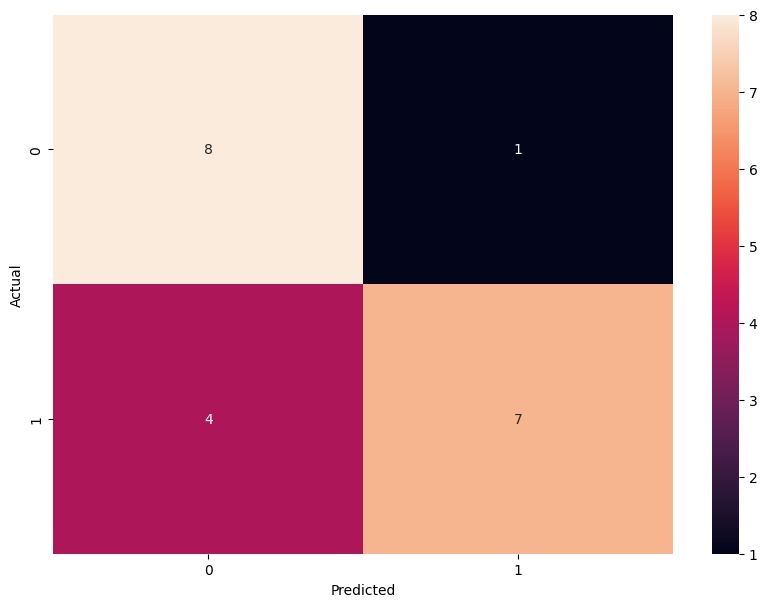

In [19]:
auroc = roc_auc_score(Y_test, results)
print(f"AUROC: {auroc}")

# Create a confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(Y_test, results)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Train Using Classification Model
We will create a embeddings using 'text-embedding-ada-002' model to help train several classification models. 

In [20]:
def get_embeddings(texts: str, model: str = "text-embedding-ada-002") -> str:
    try: 
        embeddings = []
        for text in tqdm(texts):
            text = text.replace('\n', ' ')
            response = client.embeddings.create(
                model=model,
                input=[text]
            )
            embeddings.append(response.data[0].embedding)
        return embeddings
    except Exception as e:
        print(f'Error: {e}')
        return None

In [21]:
dataset = StrokeDataset(X_train)
embeddings = get_embeddings(dataset, model="text-embedding-ada-002")

#shape of the embeddings
np.shape(embeddings)

100%|██████████| 80/80 [00:12<00:00,  6.47it/s]


(80, 1536)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

models = {'Logistic Regression': LogisticRegression(),
          'Random Forest': RandomForestClassifier(), 
          'Gradient Boosting': GradientBoostingClassifier()}

for model_name, model in models.items():
    model.fit(embeddings, Y_train)
    results = model.predict(embeddings)
    accuracy = accuracy_score(Y_train, results)
    print(f"{model_name} Accuracy: {accuracy}")

    precision = average_precision_score(Y_train, results)
    print(f"{model_name} Precision: {precision}")

    auroc = roc_auc_score(Y_train, results)
    print(f"{model_name} AUROC: {auroc}")

    cm = confusion_matrix(Y_train, results)
    print(f"{model_name} Confusion Matrix: {cm}")

Logistic Regression Accuracy: 0.5125
Logistic Regression Precision: 0.4875
Logistic Regression AUROC: 0.5
Logistic Regression Confusion Matrix: [[41  0]
 [39  0]]
Random Forest Accuracy: 1.0
Random Forest Precision: 1.0
Random Forest AUROC: 1.0
Random Forest Confusion Matrix: [[41  0]
 [ 0 39]]
Gradient Boosting Accuracy: 1.0
Gradient Boosting Precision: 1.0
Gradient Boosting AUROC: 1.0
Gradient Boosting Confusion Matrix: [[41  0]
 [ 0 39]]


100%|██████████| 20/20 [00:04<00:00,  4.38it/s]


Accuracy: 0.8
Precision: 0.7694214876033059


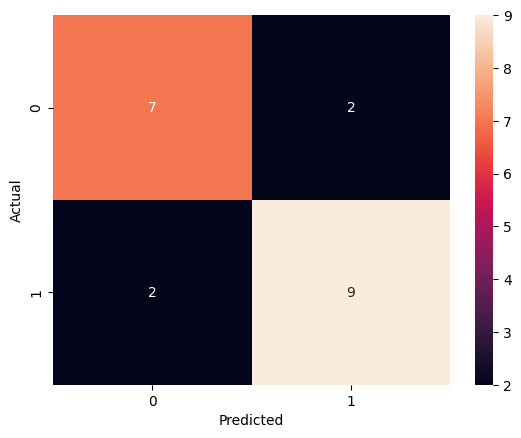

In [26]:
test_embeddings = get_embeddings(StrokeDataset(X_test), model="text-embedding-ada-002")
test_labels = Y_test

predictions = model.predict(test_embeddings)

accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy: {accuracy}")
precision = average_precision_score(test_labels, predictions)
print(f"Precision: {precision}")

# Create a confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
